In [1]:
import tensorflow as tf
tf.__version__

2025-11-06 00:06:22.081309: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-06 00:06:22.152814: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 00:06:24.066542: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


'2.20.0'

In [2]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from tensorflow.keras import (
    layers,
    models,
    regularizers,
    metrics,
    optimizers,
    callbacks,
)

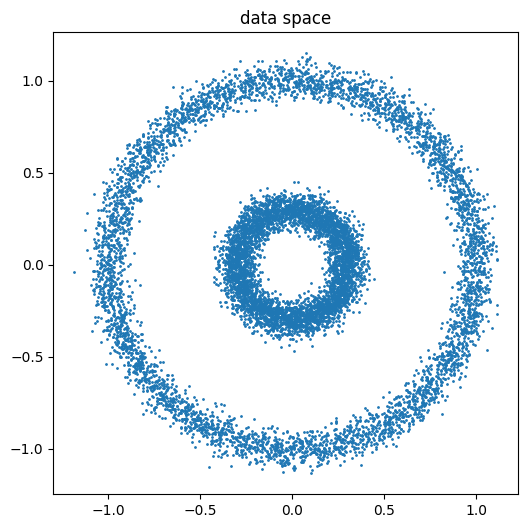

In [3]:
n_samples = 10000
X, _ = make_circles(n_samples=n_samples, noise=0.05, factor=0.3, random_state=42)
X = X.astype(np.float32)

plt.figure(figsize=(6, 6))
plt.scatter(X[:, 0], X[:, 1], s=1)
plt.title("data space")
plt.show()

In [4]:
COUPLING_DIM = 256
COUPLING_LAYERS = 12
INPUT_DIM = 2
REGULARIZATION = 0.01
BATCH_SIZE = 256
EPOCHS = 100
LEARNING_RATE = 1e-4

In [5]:
def coupling_module(input_dim, coupling_dim, reg):
    input_layer = layers.Input(shape=(input_dim,))

    l = 4
    s_layer = input_layer
    t_layer = input_layer
    for _ in range(l):
        s_layer = layers.Dense(
            coupling_dim, activation="relu", 
            kernel_regularizer=regularizers.l2(reg)
        )(s_layer)
        t_layer = layers.Dense(
            coupling_dim, activation="relu", 
            kernel_regularizer=regularizers.l2(reg)
        )(t_layer)

    s_layer = layers.Dense(
        input_dim, kernel_regularizer=regularizers.l2(reg), activation='tanh'
    )(s_layer)
    t_layer = layers.Dense(
        input_dim, kernel_regularizer=regularizers.l2(reg), activation='linear'
    )(t_layer)

    return models.Model(inputs=input_layer, 
                        outputs=[s_layer, t_layer])



In [6]:
class RealNVP(models.Model):
    def __init__(
        self, input_dim, coupling_layers, coupling_dim, regularization
    ):
        super(RealNVP, self).__init__()
        self.coupling_layers = coupling_layers
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0], scale_diag=[1.0, 1.0]
        ) # 1) стандартное двумерное гауссово распределение
        self.masks = np.array(
            [[0, 1], [1, 0]] * (coupling_layers // 2), dtype="float32"
        ) # 2) чередующийся шаблон маски
        self.loss_tracker = metrics.Mean(name="loss")
        self.layers_list = [
            coupling_module(input_dim, coupling_dim, regularization)
            for i in range(coupling_layers)
        ] # 3) список соединительных слоев

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, x, training=True): 
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.coupling_layers)[::direction]: # 4) направление движения по слоям
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) 
                   + direction * t * tf.exp(gate * s))
                + x_masked
            ) # 5) прямое и обратное уравнения
            log_det_inv += gate * tf.reduce_sum(s, axis=1) # 6) логарифм якобиана
        return x, log_det_inv

    def log_loss(self, x):
        y, logdet = self(x)
        log_likelihood = self.distribution.log_prob(y) + logdet # 7) минус логарифм вероятности
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self.log_loss(data)
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g,self.trainable_variables))
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

model = RealNVP(
    input_dim=INPUT_DIM,
    coupling_layers=COUPLING_LAYERS,
    coupling_dim=COUPLING_DIM,
    regularization=REGULARIZATION,
)

2025-11-06 00:06:27.199437: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [7]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
)

In [8]:
tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_samples):
        self.num_samples = num_samples

    def generate(self):
        # From data to latent space.
        z, _ = model(X)

        # From latent space to data.
        samples = model.distribution.sample(self.num_samples)
        x, _ = model.predict(samples, verbose=0)

        return x, z, samples

    def display(self, x, z, samples, save_to=None):
        f, axes = plt.subplots(2, 2)
        f.set_size_inches(8, 5)

        axes[0, 0].scatter(
            X[:, 0], X[:, 1], color="r", s=1
        )
        axes[0, 0].set(title="Data space X", xlabel="x_1", ylabel="x_2")
        axes[0, 0].set_xlim([-2, 2])
        axes[0, 0].set_ylim([-2, 2])
        axes[0, 1].scatter(z[:, 0], z[:, 1], color="r", s=1)
        axes[0, 1].set(title="f(X)", xlabel="z_1", ylabel="z_2")
        axes[0, 1].set_xlim([-2, 2])
        axes[0, 1].set_ylim([-2, 2])
        axes[1, 0].scatter(samples[:, 0], samples[:, 1], color="g", s=1)
        axes[1, 0].set(title="Latent space Z", xlabel="z_1", ylabel="z_2")
        axes[1, 0].set_xlim([-2, 2])
        axes[1, 0].set_ylim([-2, 2])
        axes[1, 1].scatter(x[:, 0], x[:, 1], color="g", s=1)
        axes[1, 1].set(title="g(Z)", xlabel="x_1", ylabel="x_2")
        axes[1, 1].set_xlim([-2, 2])
        axes[1, 1].set_ylim([-2, 2])

        plt.subplots_adjust(wspace=0.3, hspace=0.6)
        if save_to:
            plt.savefig(save_to)
            print(f"\nSaved to {save_to}")

        plt.show()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 1 == 0:
            x, z, samples = self.generate()
            self.display(
                x,
                z,
                samples,
                save_to="./output/generated_img_%03d.png" % (epoch),
            )


img_generator_callback = ImageGenerator(num_samples=3000)

In [9]:
import os
os.makedirs("./logs", exist_ok=True)
os.makedirs("./output", exist_ok=True)

Epoch 1/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.8314
Saved to ./output/generated_img_000.png


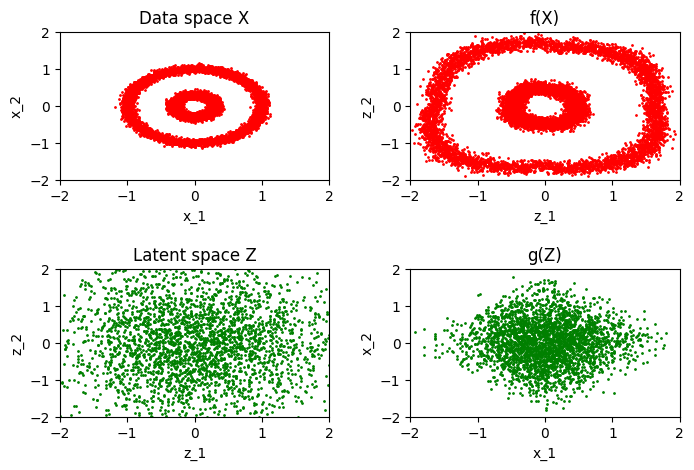

40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 185ms/step - loss: 1.7064
Epoch 2/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.5340
Saved to ./output/generated_img_001.png


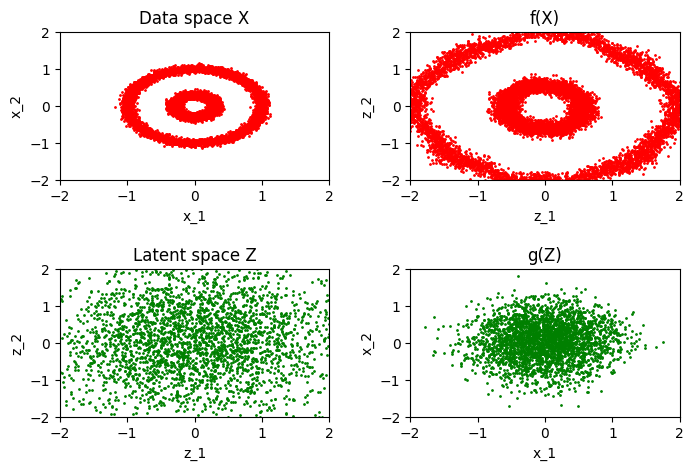

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 1.5220
Epoch 3/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 1.5190
Saved to ./output/generated_img_002.png


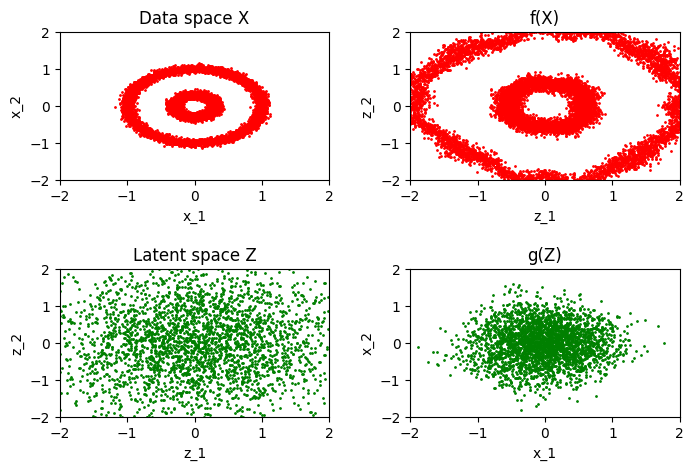

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 1.5074
Epoch 4/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.4985
Saved to ./output/generated_img_003.png


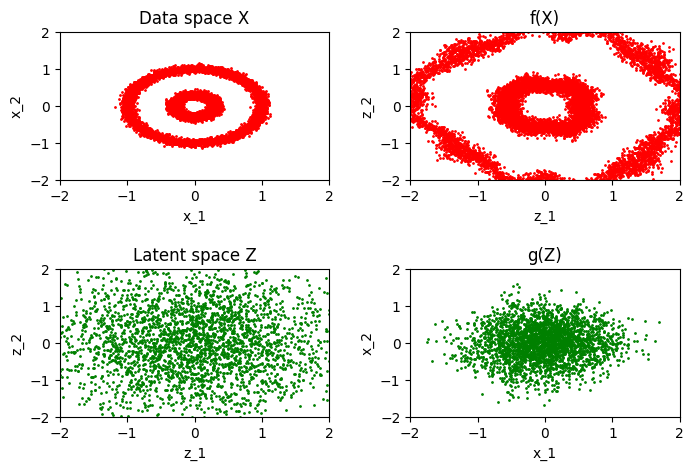

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - loss: 1.4730
Epoch 5/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.4445
Saved to ./output/generated_img_004.png


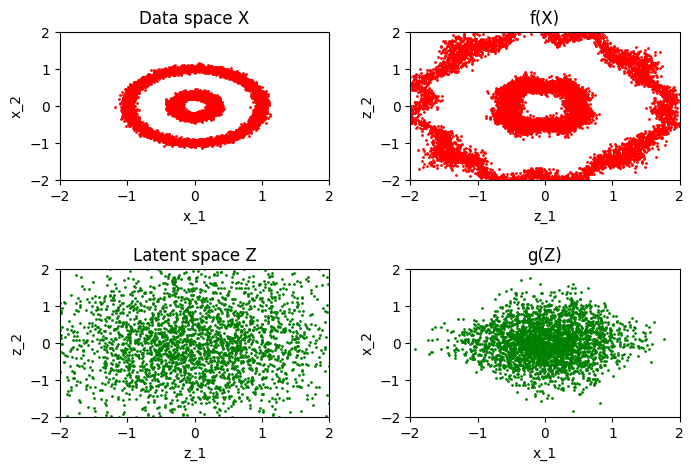

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 1.4719
Epoch 6/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.4471
Saved to ./output/generated_img_005.png


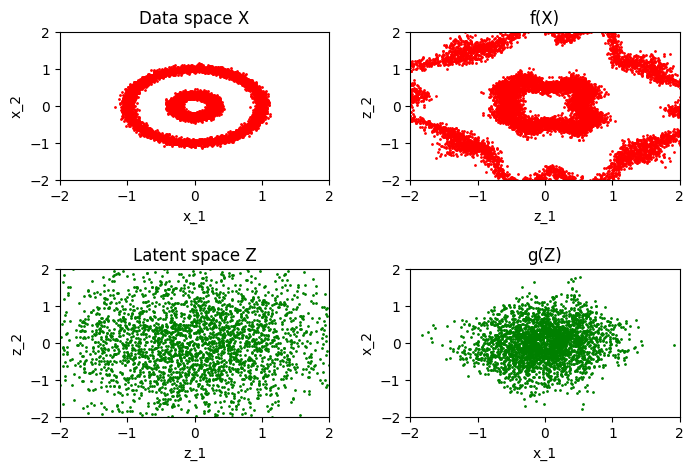

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 1.4186
Epoch 7/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.3775
Saved to ./output/generated_img_006.png


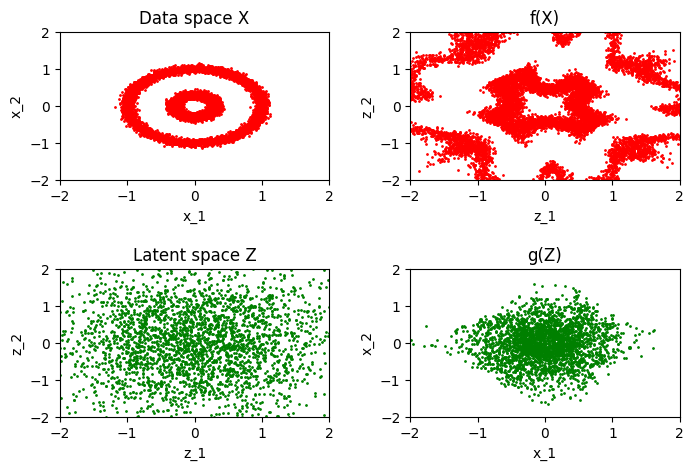

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 1.3549
Epoch 8/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.2935
Saved to ./output/generated_img_007.png


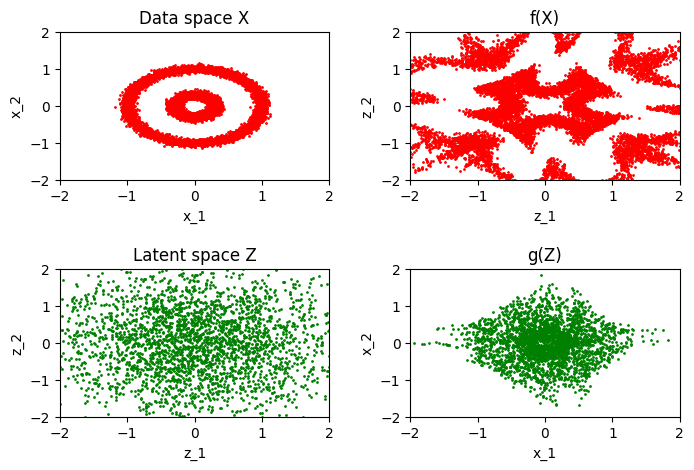

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 1.2752
Epoch 9/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.2137
Saved to ./output/generated_img_008.png


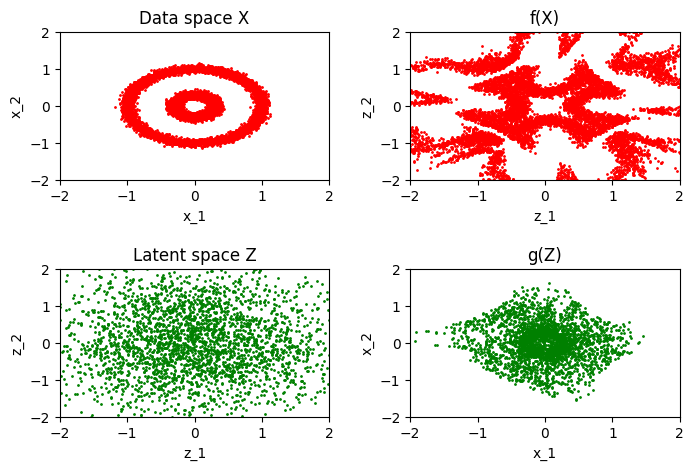

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 1.1984
Epoch 10/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 1.1390
Saved to ./output/generated_img_009.png


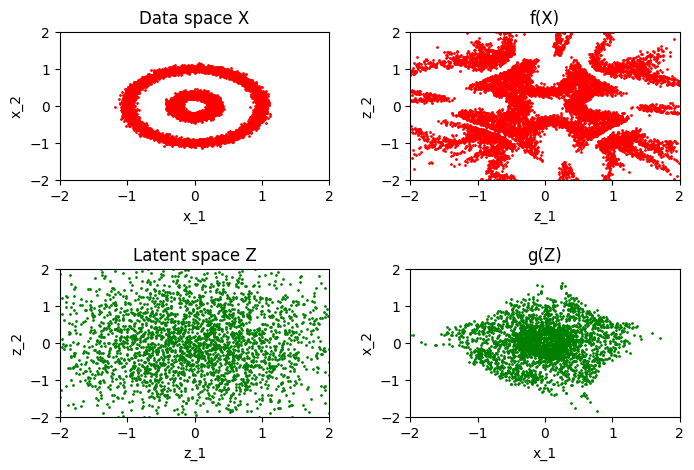

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - loss: 1.1269
Epoch 11/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1.0868
Saved to ./output/generated_img_010.png


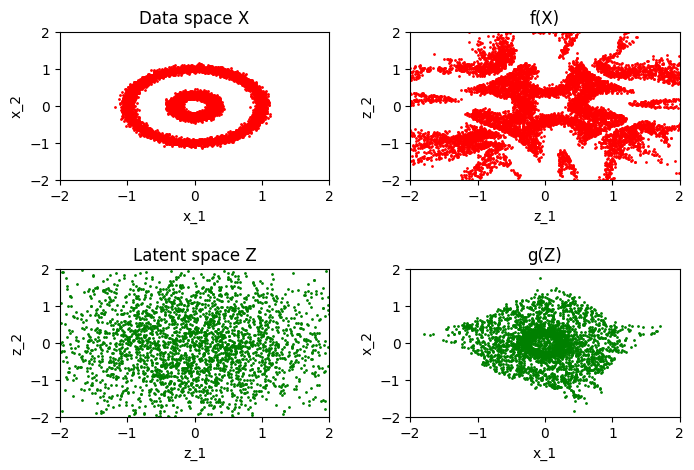

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 1.0854
Epoch 12/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 1.0597
Saved to ./output/generated_img_011.png


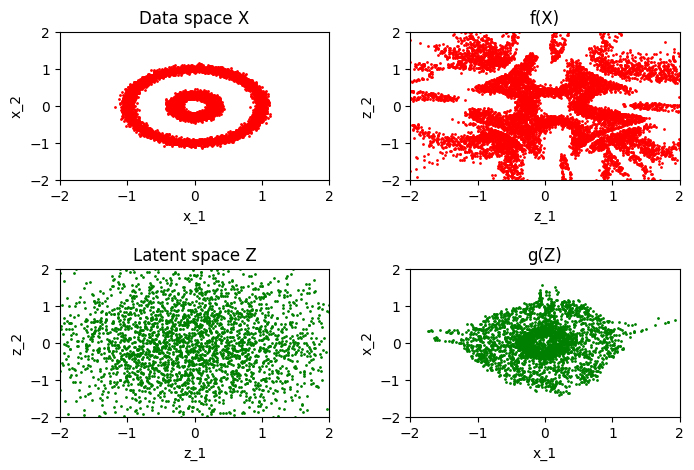

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 1.0372
Epoch 13/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.9944
Saved to ./output/generated_img_012.png


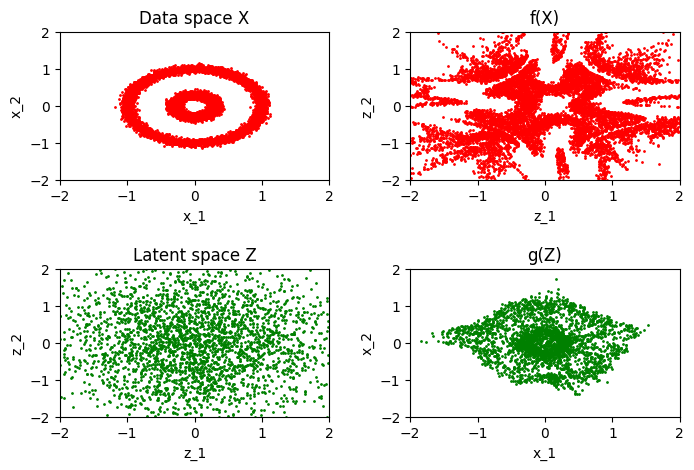

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.9950
Epoch 14/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.0580
Saved to ./output/generated_img_013.png


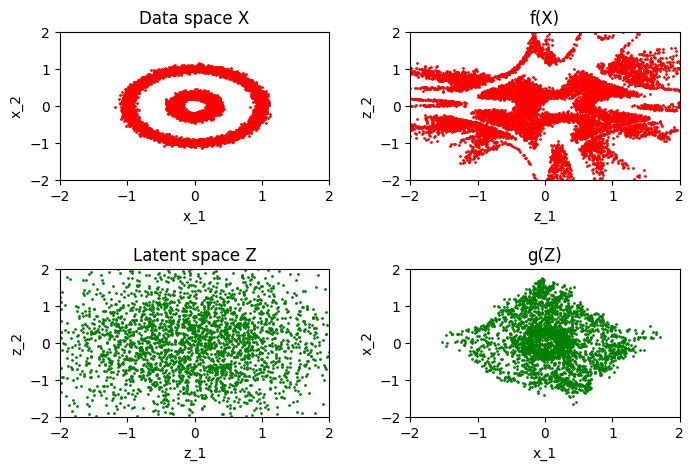

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 1.0566
Epoch 15/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.0993
Saved to ./output/generated_img_014.png


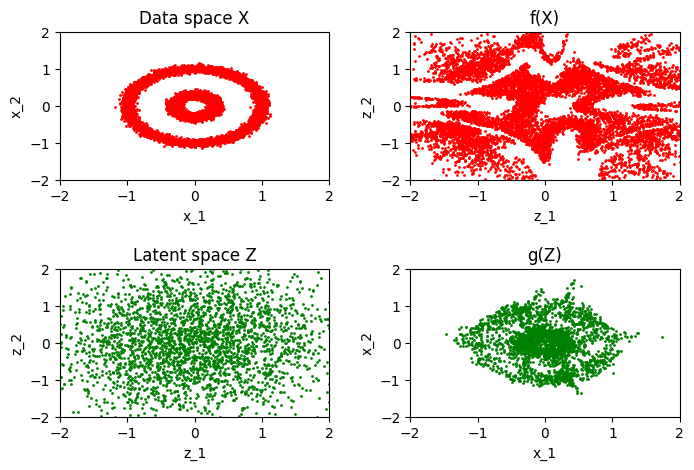

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 1.0365
Epoch 16/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.0603
Saved to ./output/generated_img_015.png


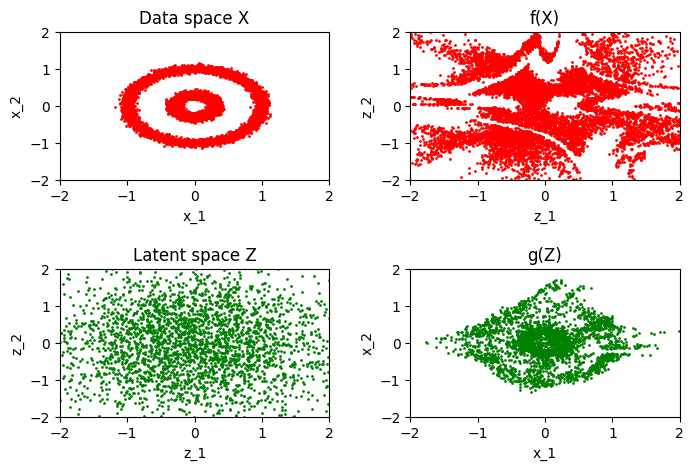

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - loss: 1.0466
Epoch 17/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.9694
Saved to ./output/generated_img_016.png


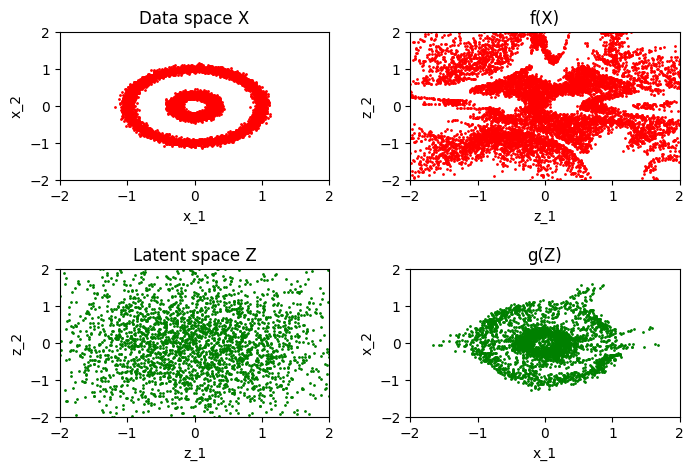

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.9471
Epoch 18/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.9213
Saved to ./output/generated_img_017.png


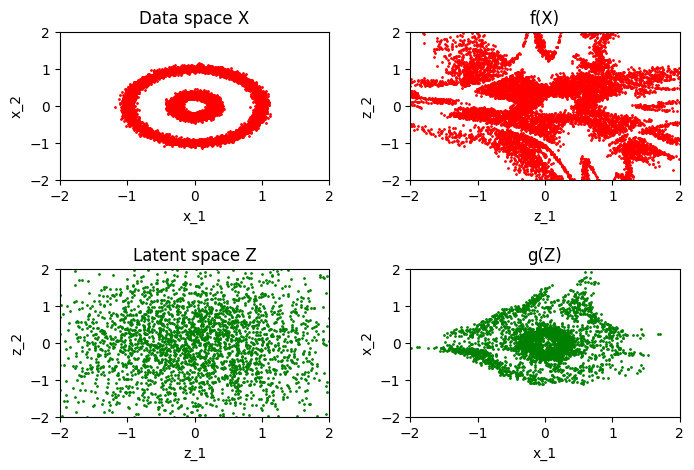

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.9404
Epoch 19/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.9933
Saved to ./output/generated_img_018.png


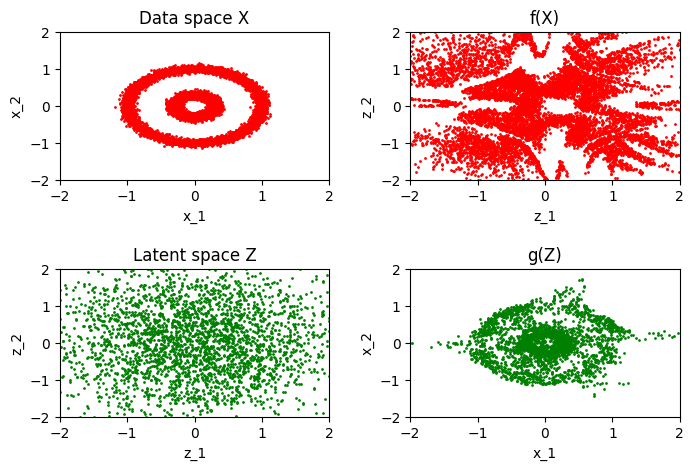

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 0.9709
Epoch 20/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.8967
Saved to ./output/generated_img_019.png


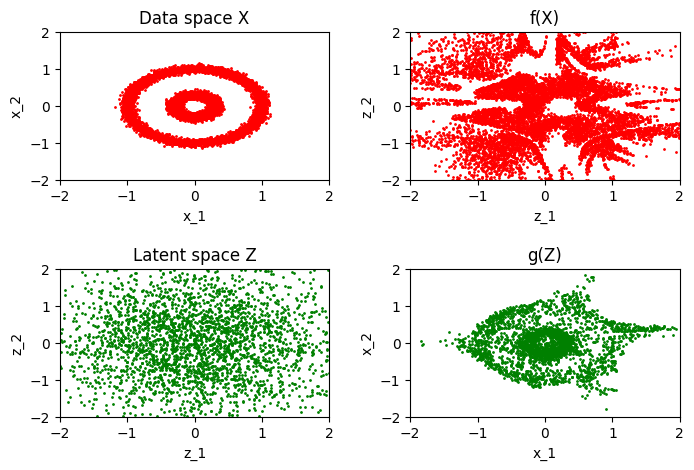

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.9188
Epoch 21/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.9307
Saved to ./output/generated_img_020.png


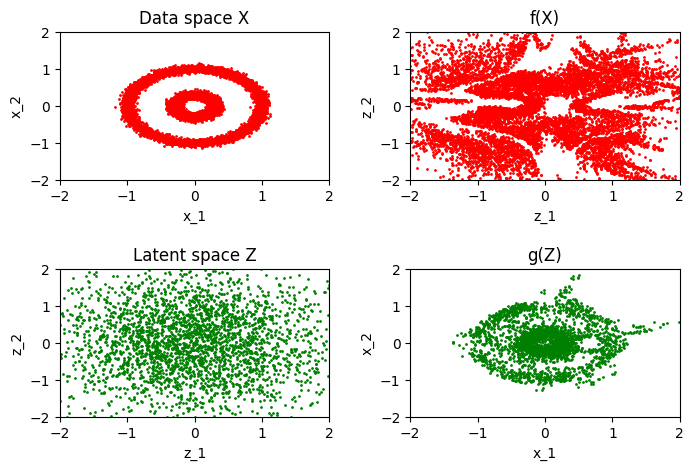

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.8982
Epoch 22/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.8411
Saved to ./output/generated_img_021.png


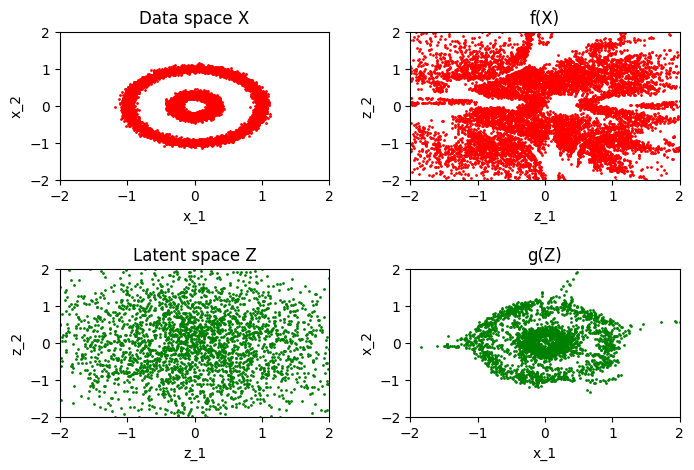

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.8460
Epoch 23/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.8419
Saved to ./output/generated_img_022.png


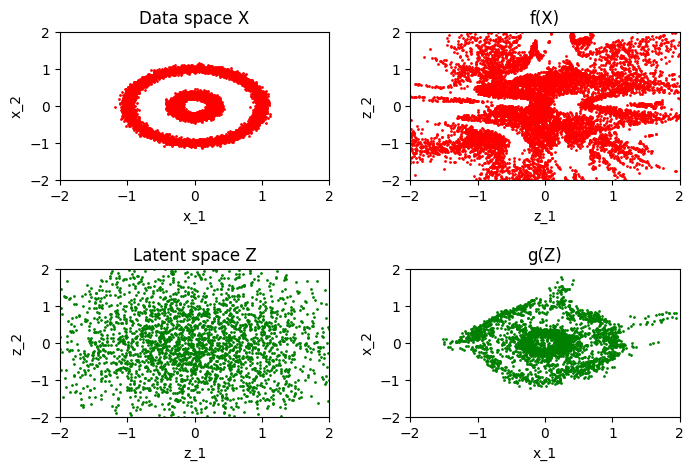

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - loss: 0.8662
Epoch 24/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.8918
Saved to ./output/generated_img_023.png


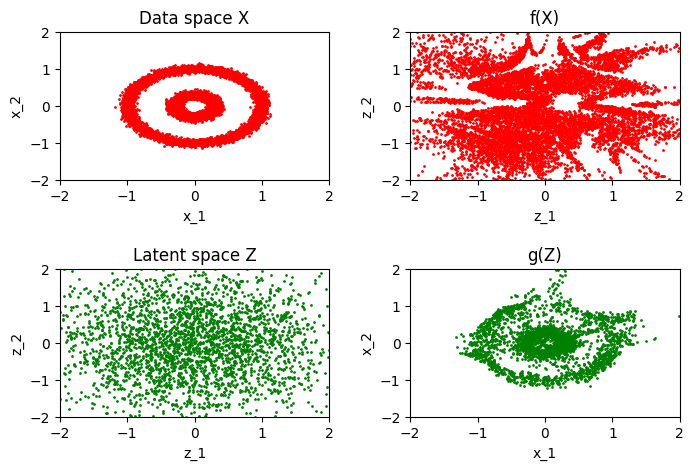

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.8760
Epoch 25/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 0.9245
Saved to ./output/generated_img_024.png


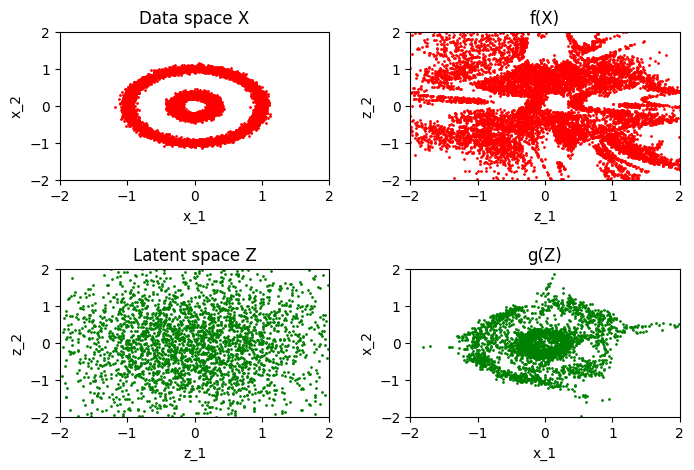

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - loss: 0.9263
Epoch 26/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - loss: 0.9134
Saved to ./output/generated_img_025.png


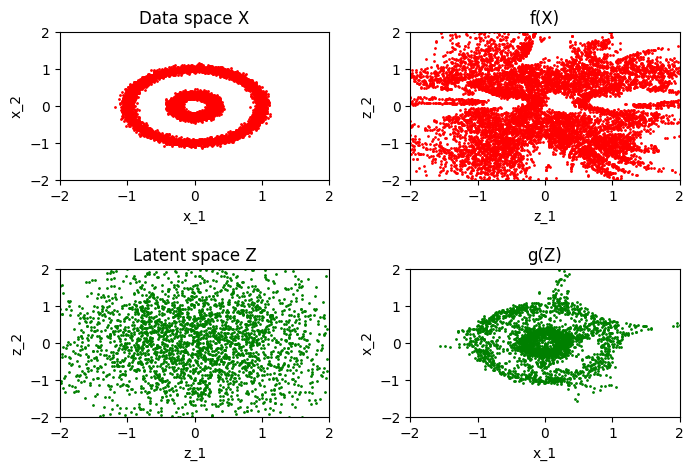

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - loss: 0.8638
Epoch 27/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - loss: 0.8333
Saved to ./output/generated_img_026.png


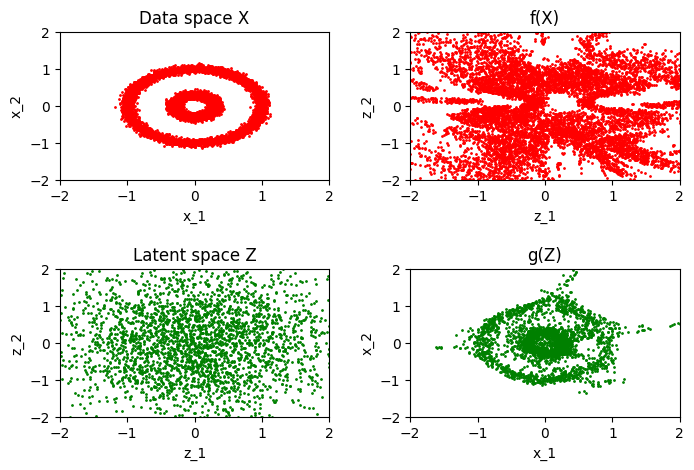

40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 163ms/step - loss: 0.8263
Epoch 28/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - loss: 0.8044
Saved to ./output/generated_img_027.png


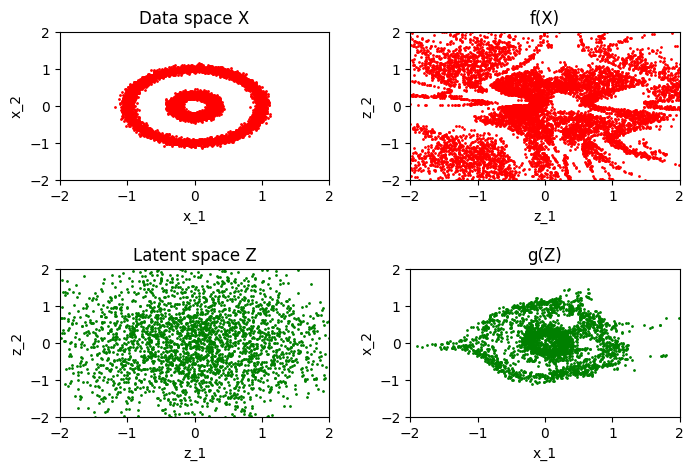

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 0.8484
Epoch 29/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 1.1686
Saved to ./output/generated_img_028.png


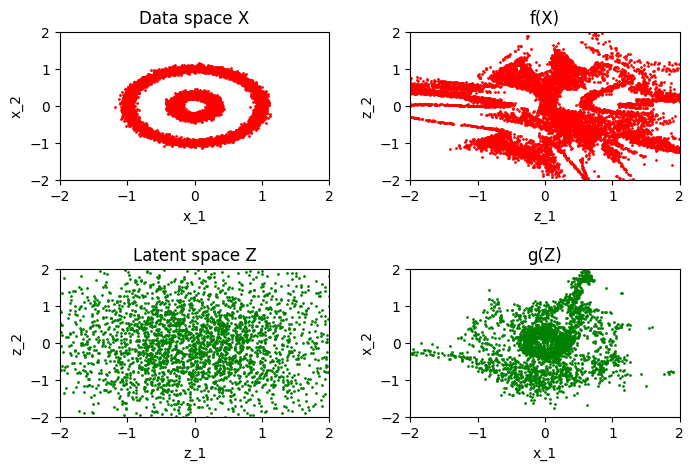

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 1.2920
Epoch 30/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.1985
Saved to ./output/generated_img_029.png


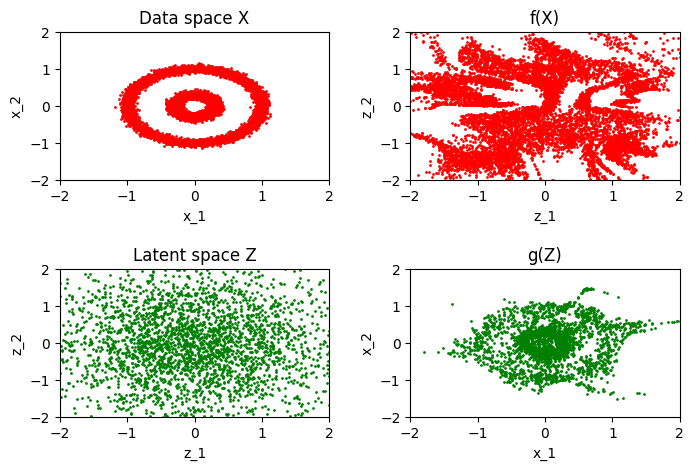

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - loss: 1.1403
Epoch 31/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.0026
Saved to ./output/generated_img_030.png


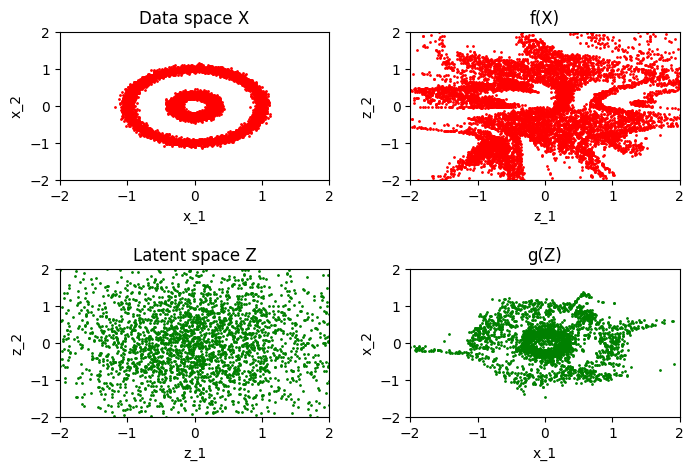

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - loss: 1.0064
Epoch 32/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.9371
Saved to ./output/generated_img_031.png


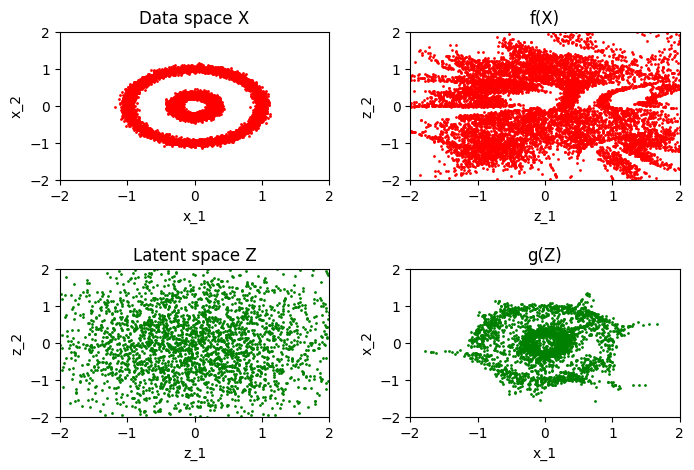

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.9111
Epoch 33/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.8749
Saved to ./output/generated_img_032.png


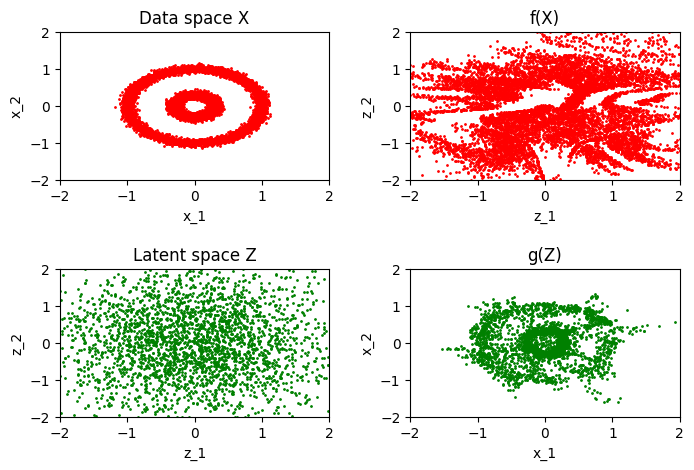

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - loss: 0.8862
Epoch 34/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.8891
Saved to ./output/generated_img_033.png


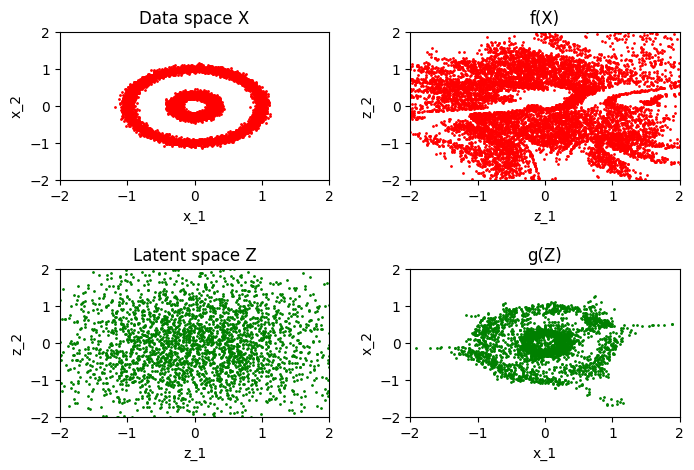

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - loss: 0.8859
Epoch 35/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8480
Saved to ./output/generated_img_034.png


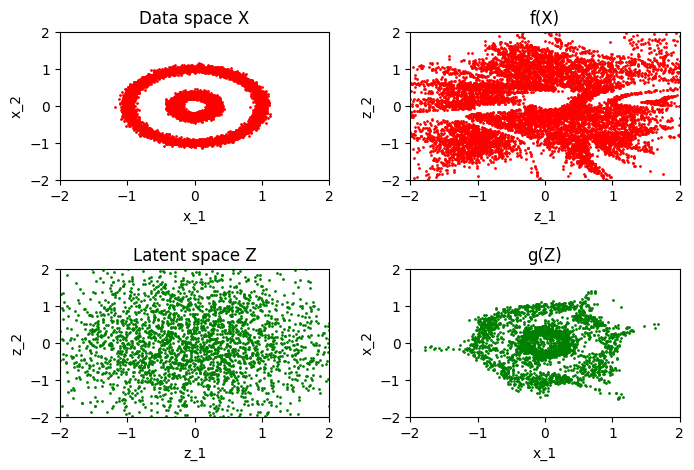

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.8446
Epoch 36/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.8611
Saved to ./output/generated_img_035.png


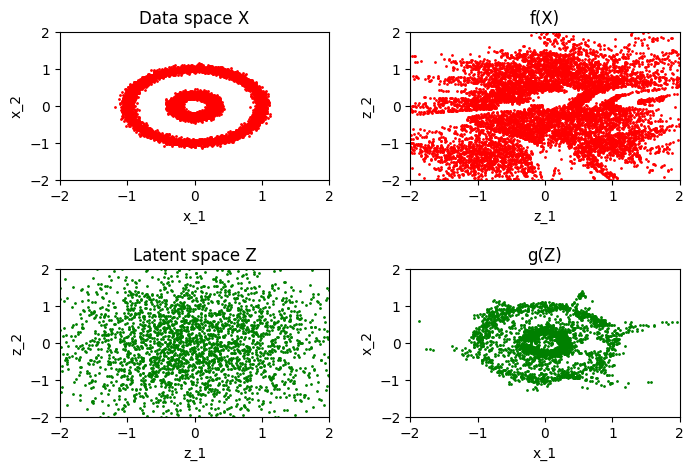

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - loss: 0.8379
Epoch 37/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.8239
Saved to ./output/generated_img_036.png


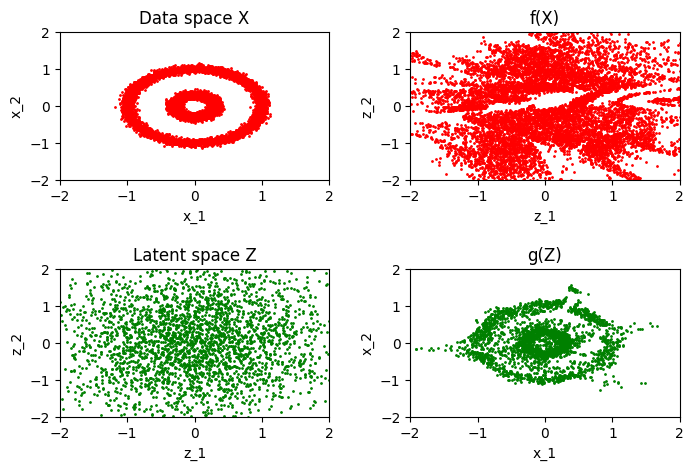

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.8192
Epoch 38/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.7606
Saved to ./output/generated_img_037.png


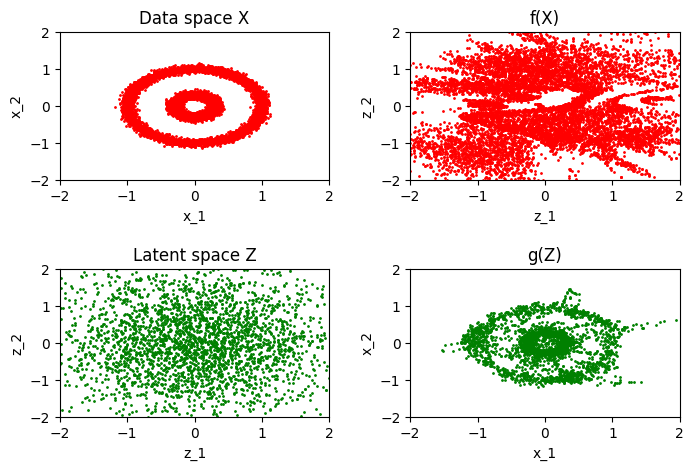

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.7723
Epoch 39/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.7960
Saved to ./output/generated_img_038.png


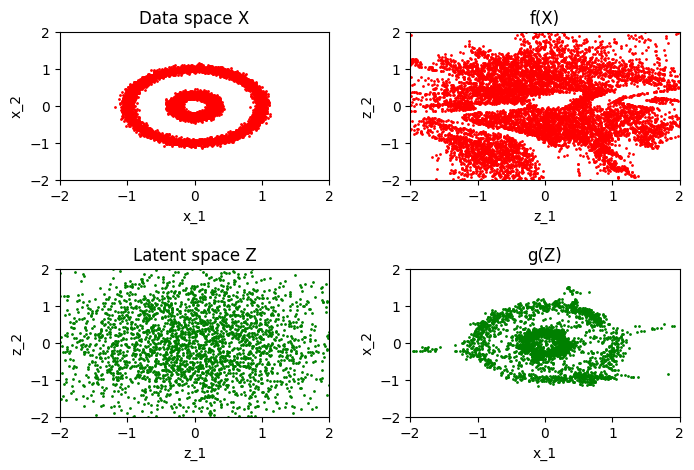

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.8072
Epoch 40/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.7683
Saved to ./output/generated_img_039.png


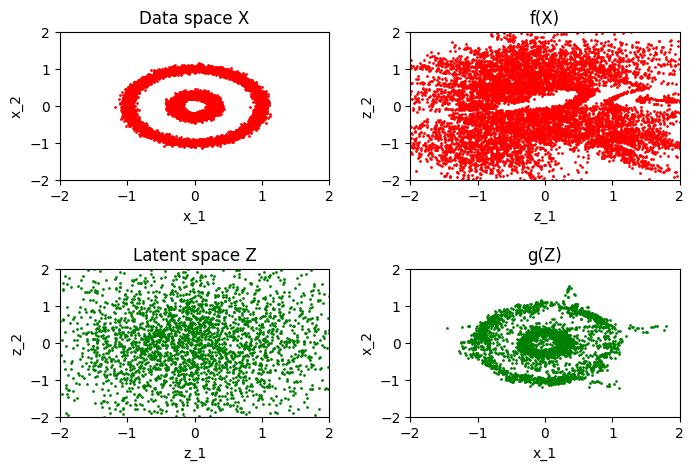

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - loss: 0.7553
Epoch 41/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.7520
Saved to ./output/generated_img_040.png


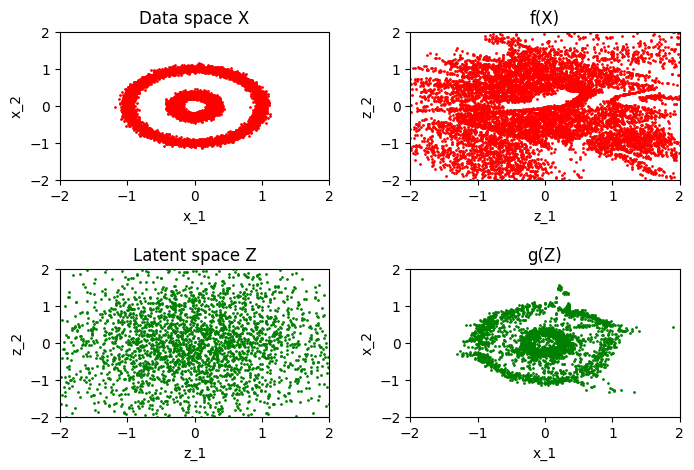

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.7491
Epoch 42/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.7688
Saved to ./output/generated_img_041.png


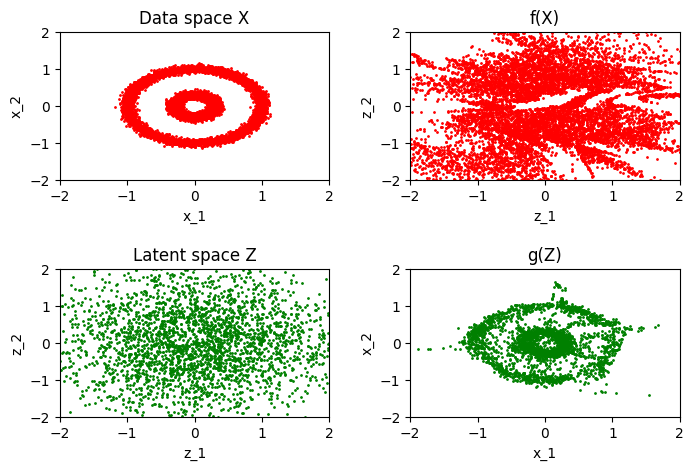

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - loss: 0.7414
Epoch 43/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.7309
Saved to ./output/generated_img_042.png


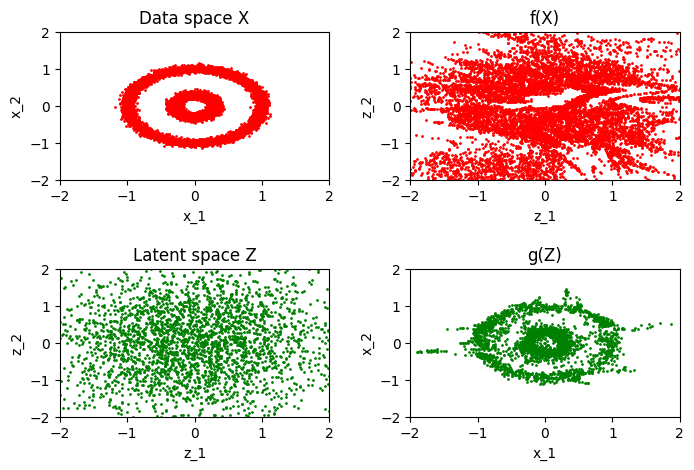

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - loss: 0.7163
Epoch 44/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 0.7752
Saved to ./output/generated_img_043.png


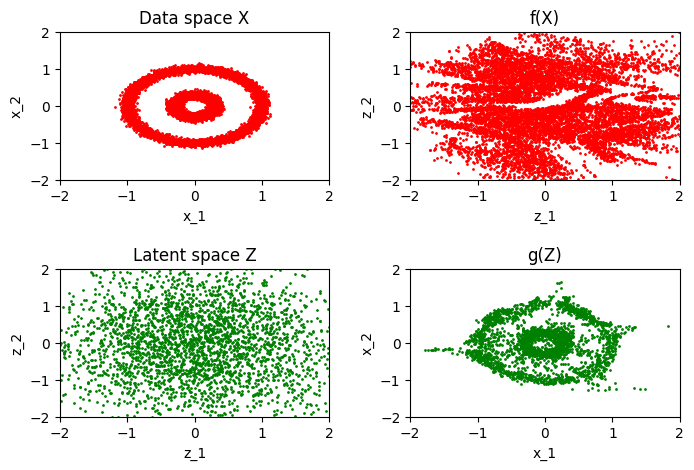

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - loss: 0.7716
Epoch 45/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - loss: 0.7565
Saved to ./output/generated_img_044.png


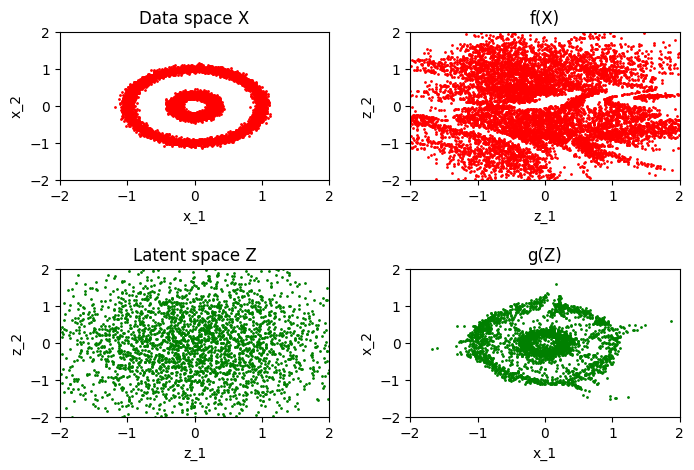

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - loss: 0.7406
Epoch 46/100
39/40 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.7766
Saved to ./output/generated_img_045.png


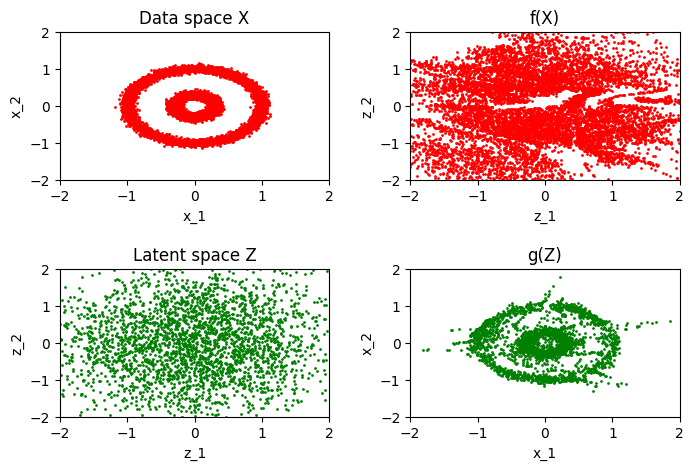

40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - loss: 0.7335


In [10]:
model.fit(
    X,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tensorboard_callback,
        img_generator_callback,
        callbacks.EarlyStopping(
            monitor='loss',
            patience=3,
            restore_best_weights=True,
            start_from_epoch=30,
        ),
    ],
)

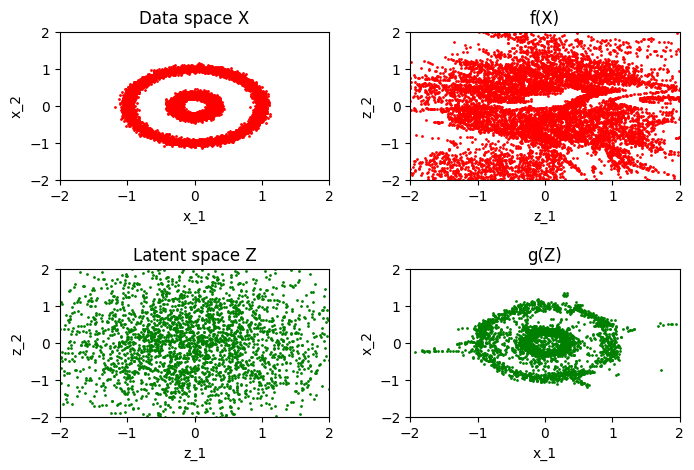

In [11]:
x, z, samples = img_generator_callback.generate()
img_generator_callback.display(x, z, samples)

In [18]:
!rm -f ./output/generated_video.mp4
!ffmpeg -r 5 -i ./output/generated_img_%03d.png -c:v libx264 -pix_fmt yuv420p ./output/generated_video.mp4

ffmpeg version n8.0 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 15.2.1 (GCC) 20250813
  configuration: --prefix=/usr --disable-debug --disable-static --disable-stripping --enable-amf --enable-avisynth --enable-cuda-llvm --enable-lto --enable-fontconfig --enable-frei0r --enable-gmp --enable-gnutls --enable-gpl --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libdav1d --enable-libdrm --enable-libdvdnav --enable-libdvdread --enable-libfreetype --enable-libfribidi --enable-libglslang --enable-libgsm --enable-libharfbuzz --enable-libiec61883 --enable-libjack --enable-libjxl --enable-libmodplug --enable-libmp3lame --enable-libopencore_amrnb --enable-libopencore_amrwb --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libplacebo --enable-libpulse --enable-librav1e --enable-librsvg --enable-librubberband --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libsvtav1 --enable

In [19]:
from IPython.display import Video
Video("./output/generated_video.mp4", embed=True)

In [20]:
bins = 50
range_ = [[-2, 2], [-2, 2]]

hist_original, xedges, yedges = np.histogram2d(X[:, 0], X[:, 1], bins=bins, range=range_)
hist_generated, _, _ = np.histogram2d(x[:, 0], x[:, 1], bins=bins, range=range_)

epsilon = 1e-4
p_original = (hist_original + epsilon) / (hist_original.sum() + epsilon * bins * bins)
p_generated = (hist_generated + epsilon) / (hist_generated.sum() + epsilon * bins * bins)

p_original_flat = p_original.flatten()
p_generated_flat = p_generated.flatten()

kl_loss = tf.keras.losses.KLDivergence()
kl_value = kl_loss(p_original_flat, p_generated_flat).numpy()

print(f"KL-Divergence (Original || Generated): {kl_value:.4f}")

KL-Divergence (Original || Generated): 0.6618
